In [ ]:
'''
In this notebook, I have compared ARIMA and ARIMAX for sales forecasting.
'''

In [343]:
import numpy as np
import pandas as pd
import os
import datetime
import warnings
import itertools
import sys
warnings.filterwarnings("ignore")

In [344]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import pmdarima as pm

In [345]:
train_data_path =  'yds_train2018.csv'
train_df = pd.read_csv('data/'+train_data_path) #loading train data

test_data_path =  'yds_test2018.csv'
test_df = pd.read_csv('data/'+test_data_path) # loading test data

In [346]:
train_df.head(2)

,S_No,Year,Month,Week,Merchant_ID,Product_ID,Country,Sales
0,1,2013,1,1,ar00001,1,Argentina,157500.0
1,2,2013,1,1,ar00003,1,Argentina,39375.0


In [347]:
test_df.head(2)

,S_No,Year,Month,Product_ID,Country,Sales
0,79073,2016,4,1,Argentina,NaN
1,79074,2016,5,1,Argentina,NaN


In [348]:
'''
As the train data in on Merchant level, I doppped 'Merchant_ID' and rolled up the data to Product level by summing up the Sales values.
'''
train_df.drop(['Merchant_ID', 'Week'], axis=1, inplace=True)
train_df = train_df.groupby(['Country', 'Year', 'Month', 'Product_ID'])
train_df = train_df.agg('sum')['Sales'].reset_index()
train_df.columns = ['Country', 'Year', 'Month', 'Product_ID', 'Monthly_Productwise_sales']

In [349]:
train_df.head(2)

,Country,Year,Month,Product_ID,Monthly_Productwise_sales
0,Argentina,2013,1,1,34346025.00
1,Argentina,2013,1,2,2751851.48


In [350]:
expense_df = pd.read_csv('data\promotional_expense.csv')
expense_df.columns = ['Year', 'Month', 'Country', 'Product_ID', 'Expense']

train_df = pd.merge(train_df, expense_df, on=['Year', 'Month', 'Country', 'Product_ID'], how='left')

In [351]:
'''
To include time dimension in the train dataset, I added 'Day' (day of the Year) feature. Then formatted the string to datetime.
'''
train_df['Day'] = 1
train_df['Date'] = train_df['Year'].astype(str) + '/' + train_df['Month'].astype(str) + '/' + train_df['Day'].astype(str)
train_df['Date'] = pd.to_datetime(train_df['Date'], format = '%Y/%m/%d')

In [352]:
'''
The information of Year, Month and Week are captured in  Date feature. Hence I droppped it. Added Date feature as the Index of dataframe.
'''
train_df.drop('Year', axis=1, inplace=True)
train_df.drop('Month', axis=1, inplace=True)
train_df.drop('Day', axis=1, inplace=True)

train_df.index = train_df['Date']
train_df.drop('Date', axis=1, inplace=True)
train_df.columns = ['Country', 'Product_ID', 'Sales', 'Expense']
train_df.head(2)

,Country,Product_ID,Sales,Expense
Date,,,,
2013-01-01,Argentina,1,34346025.00,14749.307
2013-01-01,Argentina,2,2751851.48,1329.374


#### TS data points in each group

In [353]:
for df_name, group in train_df.groupby(['Country','Product_ID']):
    print (df_name, '-->', group.shape[0])

('Argentina', 1) --> 39
('Argentina', 2) --> 39
('Argentina', 3) --> 24
('Belgium', 2) --> 39
('Columbia', 1) --> 39
('Columbia', 2) --> 39
('Columbia', 3) --> 28
('Denmark', 2) --> 39
('England', 4) --> 34
('England', 5) --> 34
('Finland', 4) --> 34


#### NULL values in each Sales data

In [354]:
for df_name, group in train_df.groupby(['Country','Product_ID']):
    print (df_name, '-->', group['Sales'].isnull().sum())

('Argentina', 1) --> 0
('Argentina', 2) --> 0
('Argentina', 3) --> 0
('Belgium', 2) --> 0
('Columbia', 1) --> 0
('Columbia', 2) --> 0
('Columbia', 3) --> 0
('Denmark', 2) --> 0
('England', 4) --> 0
('England', 5) --> 0
('Finland', 4) --> 0


#### NULL values in each Expense data

In [355]:
for df_name, group in train_df.groupby(['Country','Product_ID']):
    print (df_name, '-->', group['Expense'].isnull().sum())

('Argentina', 1) --> 0
('Argentina', 2) --> 0
('Argentina', 3) --> 24
('Belgium', 2) --> 0
('Columbia', 1) --> 0
('Columbia', 2) --> 0
('Columbia', 3) --> 28
('Denmark', 2) --> 0
('England', 4) --> 0
('England', 5) --> 0
('Finland', 4) --> 0


In [356]:
'''
Expense value is not given for Argentina-Product3 & Columbia-Product3
'''

'\nExpense value is not given for Argentina-Product3 & Columbia-Product3\n'

In [357]:
'''
To bring the data down to datetime, the dataset was groupped with Country, Product_ID and stored each group in 'dataframes' list. 
ARIMA can be applied at this level (to each group seperately).
'''

train_df = train_df.sort_values(['Country','Product_ID', 'Date'])

### Checking if the TS in each group is Statianary/ Non-Statianary?

In [358]:
from statsmodels.tsa.stattools import adfuller

temp = pd.DataFrame()

stationary_list = []
p_value_list = []
country_list = []
product_ID_list = []

for name, group in train_df.groupby(['Country','Product_ID']):
    group = group.sort_values('Date')
    result = adfuller(group['Sales'].dropna())
    p_value_list.append(result[1])
    country_list.append(name[0])
    product_ID_list.append(name[1])
    

temp['Country'] = country_list
temp['Product_ID'] = product_ID_list
temp['p_value'] = p_value_list
temp['is_Stationary'] = temp['p_value'].apply(lambda x: "Y" if (x<0.05) else "N")
temp

,Country,Product_ID,p_value,is_Stationary
0,Argentina,1,0.984560,N
1,Argentina,2,0.377056,N
2,Argentina,3,0.069589,N
3,Belgium,2,0.846854,N
4,Columbia,1,0.002789,Y
5,Columbia,2,0.051805,N
6,Columbia,3,0.998853,N
7,Denmark,2,0.988900,N
8,England,4,0.200544,N
9,England,5,0.004126,Y


In [359]:
from pmdarima.arima.utils import ndiffs

    
def get_d_value(is_Stationary, country, product_id):
    if (is_Stationary == 'Y'):
        return 0
    else:
        y = train_df[(train_df['Country'] == country) & (train_df['Product_ID'] == product_id)]['Sales'].dropna().values
        return ndiffs(y, test='kpss')
    
    
temp['d_value'] = temp.apply(lambda x: get_d_value(x['is_Stationary'], x['Country'], x['Product_ID']), axis=1)
temp

,Country,Product_ID,p_value,is_Stationary,d_value
0,Argentina,1,0.984560,N,1
1,Argentina,2,0.377056,N,1
2,Argentina,3,0.069589,N,1
3,Belgium,2,0.846854,N,1
4,Columbia,1,0.002789,Y,0
5,Columbia,2,0.051805,N,1
6,Columbia,3,0.998853,N,2
7,Denmark,2,0.988900,N,1
8,England,4,0.200544,N,0
9,England,5,0.004126,Y,0


In [360]:
train_df.head(2)

,Country,Product_ID,Sales,Expense
Date,,,,
2013-01-01,Argentina,1,34346025.0,14749.307
2013-02-01,Argentina,1,32005575.0,12187.566


Country: Argentina,   Product_ID: 1,   d_value: 1


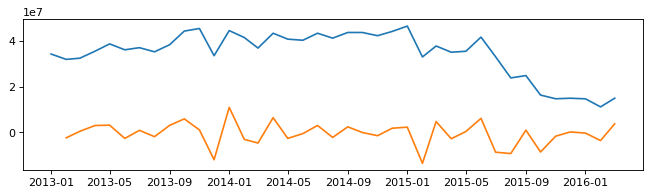

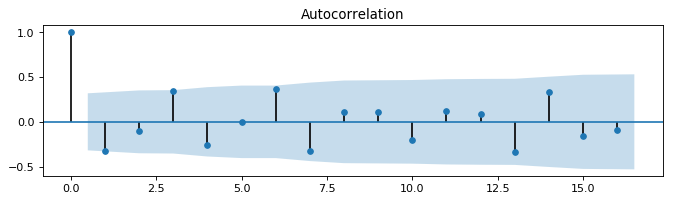

---------------------------------------------------------------------------------------------------
Country: Argentina,   Product_ID: 2,   d_value: 1


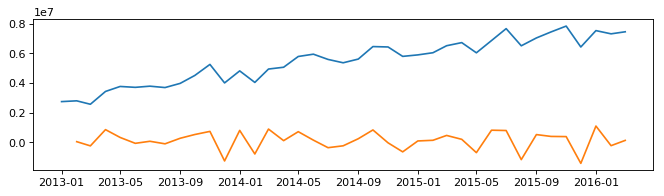

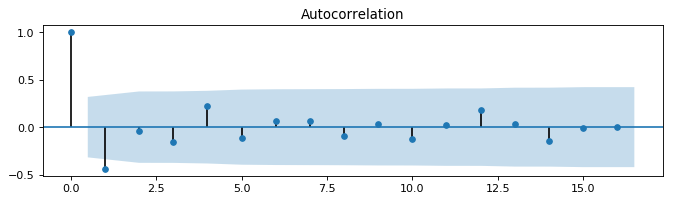

---------------------------------------------------------------------------------------------------
Country: Argentina,   Product_ID: 3,   d_value: 1


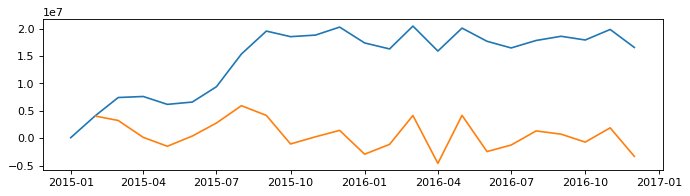

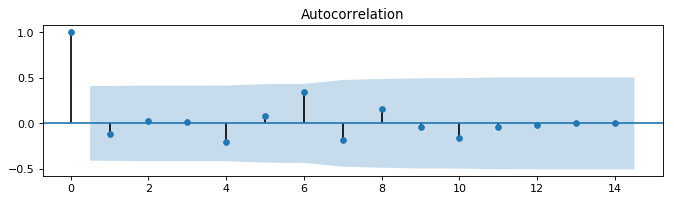

---------------------------------------------------------------------------------------------------
Country: Belgium,   Product_ID: 2,   d_value: 1


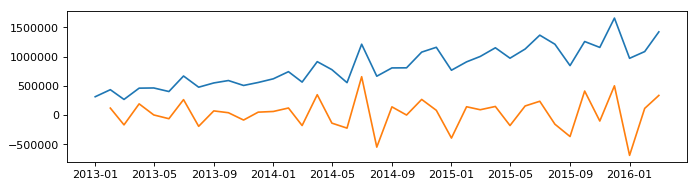

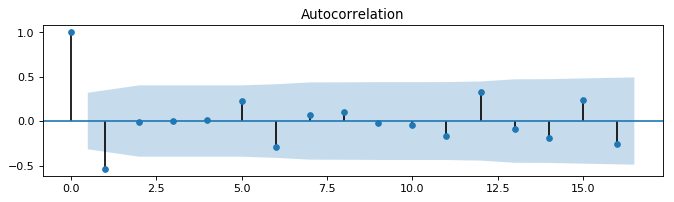

---------------------------------------------------------------------------------------------------
Country: Columbia,   Product_ID: 1,   d_value: 0


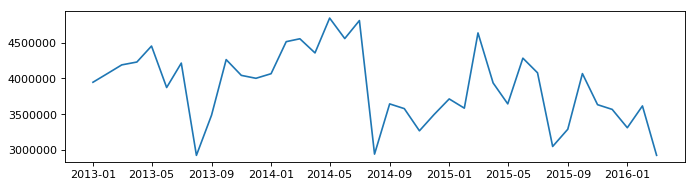

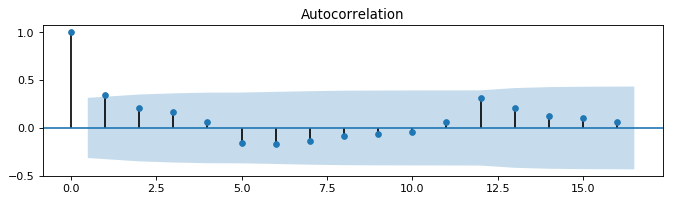

---------------------------------------------------------------------------------------------------
Country: Columbia,   Product_ID: 2,   d_value: 1


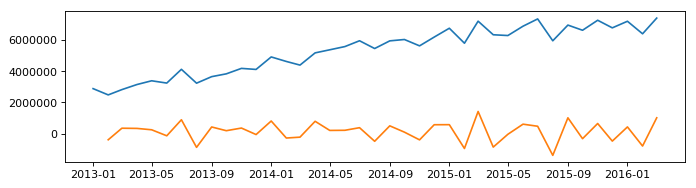

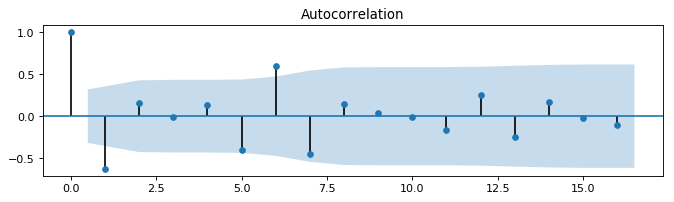

---------------------------------------------------------------------------------------------------
Country: Columbia,   Product_ID: 3,   d_value: 2


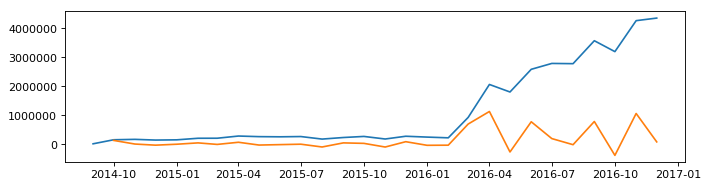

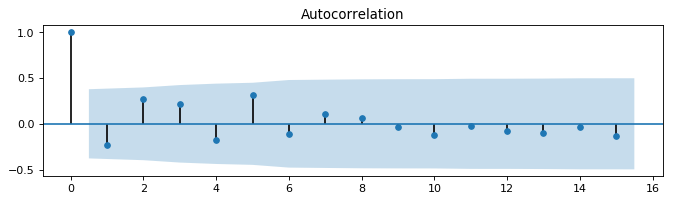

---------------------------------------------------------------------------------------------------
Country: Denmark,   Product_ID: 2,   d_value: 1


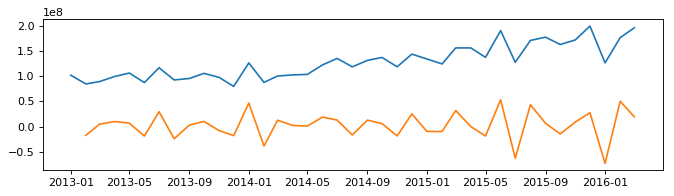

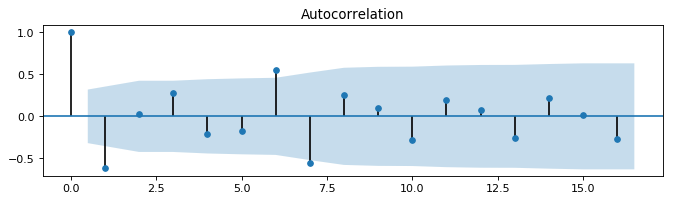

---------------------------------------------------------------------------------------------------
Country: England,   Product_ID: 4,   d_value: 0


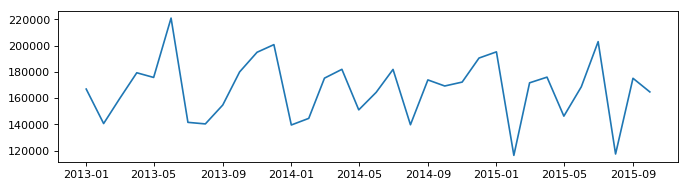

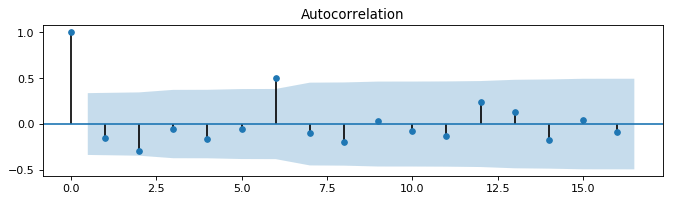

---------------------------------------------------------------------------------------------------
Country: England,   Product_ID: 5,   d_value: 0


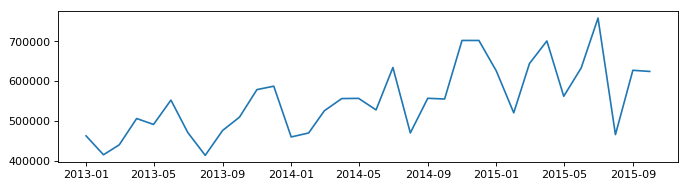

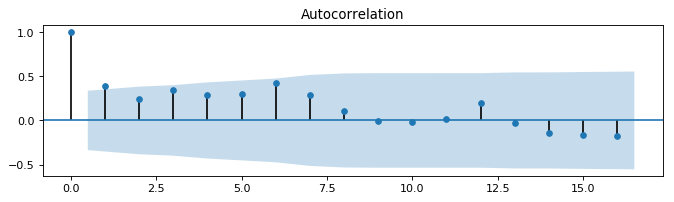

---------------------------------------------------------------------------------------------------
Country: Finland,   Product_ID: 4,   d_value: 0


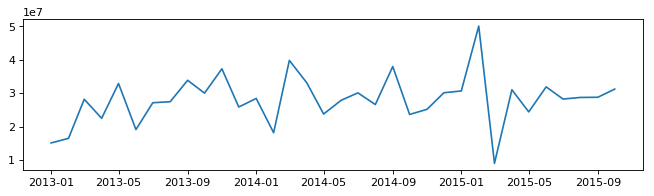

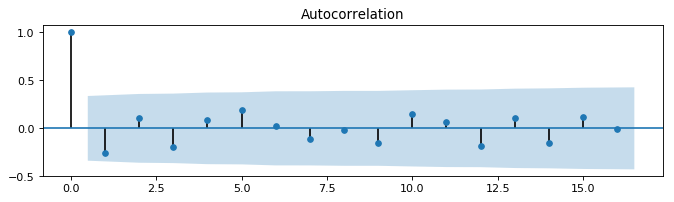

---------------------------------------------------------------------------------------------------


In [361]:
plt.rcParams.update({'figure.figsize':(10,2.5), 'figure.dpi':80})

for i in range(11):
    country, product_id, d_value = temp.iloc[i]['Country'], temp.iloc[i]['Product_ID'], temp.iloc[i]['d_value']
    
    print ("Country: " + country + ",   Product_ID: " + str(product_id) + ",   d_value: " + str(d_value))
    
    if (d_value == 0):
        plt.plot(train_df[(train_df['Country'] == country) & (train_df['Product_ID'] == product_id)]['Sales'])
        plot_acf(train_df[(train_df['Country'] == country) & (train_df['Product_ID'] == product_id)]['Sales'])
        
    else:
        plt.plot(train_df[(train_df['Country'] == country) & (train_df['Product_ID'] == product_id)]['Sales'])
        plt.plot(train_df[(train_df['Country'] == country) & (train_df['Product_ID'] == product_id)]['Sales'].diff())
        plot_acf(train_df[(train_df['Country'] == country) & (train_df['Product_ID'] == product_id)]['Sales'].diff().dropna())
    plt.show()
    print ('---------------------------------------------------------------------------------------------------')

In [362]:
def get_forecast_metrics(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    smape = np.sum( np.abs(forecast - actual)/ (np.abs(actual)+np.abs(forecast))*0.5 ) * 100/len(forecast)  #sMAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],  actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],  actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return (mape,  smape, me,  mae,  mpe, rmse, corr, minmax)

# Using Auto-Arima for forecasting

In [372]:
def get_model_summary(ts, expense=None):
    model = pm.auto_arima(ts, exogenous=expense, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    return model

### ARIMA - Forecast without using Expense data

In [373]:
best_models = {}

for name, group in train_df.groupby(['Country', 'Product_ID']):
    print (name)
    
    group = group.sort_values('Date', ascending=True)
    ts = group['Sales'].values
    train_X, test_X = ts[: int(len(ts)*80/100)], ts[int(len(ts)*80/100) :]
    best_models[name[0] + '_' + str(name[1])] = get_model_summary(train_X)

('Argentina', 1)
Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1015.903, BIC=1018.705, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1013.654, BIC=1017.858, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1012.899, BIC=1017.103, Time=0.017 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1013.921, BIC=1015.323, Time=0.004 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1015.001, BIC=1020.605, Time=0.033 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1015.207, BIC=1020.812, Time=0.027 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1016.672, BIC=1023.678, Time=0.077 seconds
Total fit time: 0.180 seconds
('Argentina', 2)
Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=880.880, BIC=883.683, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=880.516, BIC=884.720, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0

Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1075.826, BIC=1084.029, Time=0.054 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1083.701, BIC=1090.537, Time=0.040 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1065.865, BIC=1075.436, Time=0.238 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,2,3)x(0,0,0,0) [intercept=True]; AIC=1072.273, BIC=1081.844, Time=0.198 seconds
Near non-invertible roots for order (2, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=1080.618, BIC=1088.822, Time=0.110 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1074.359, BIC=1082.563, Time=0.100 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1081.556, BIC=1088.392, Time=0.036 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=Tr

Argentina_1


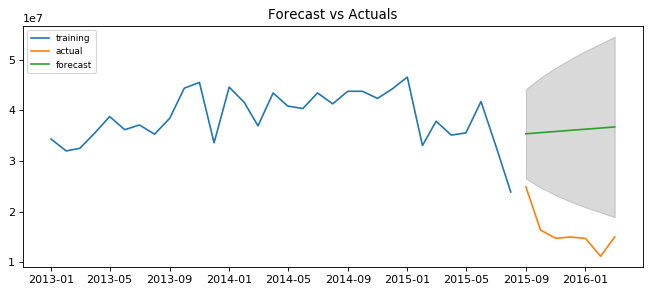

---------------------------------------------------------------------------------------------------
Argentina_2


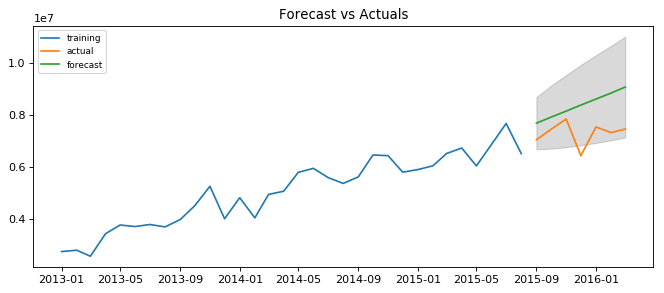

---------------------------------------------------------------------------------------------------
Argentina_3


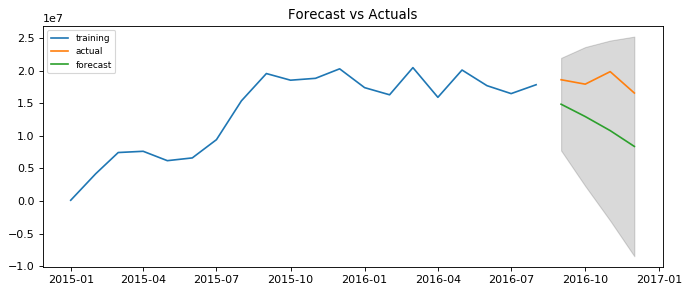

---------------------------------------------------------------------------------------------------
Belgium_2


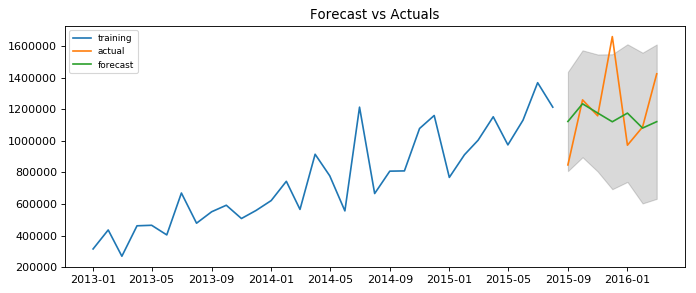

---------------------------------------------------------------------------------------------------
Columbia_1


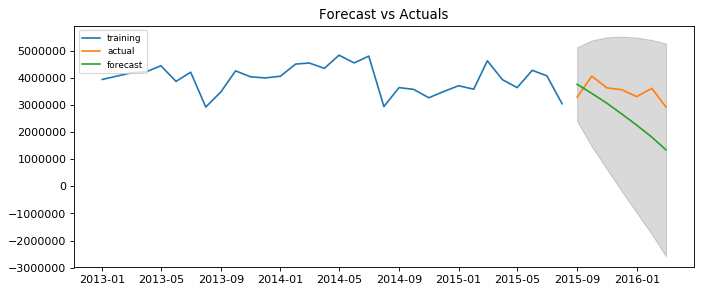

---------------------------------------------------------------------------------------------------
Columbia_2


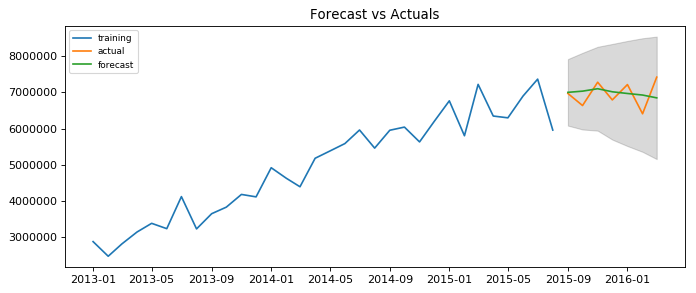

---------------------------------------------------------------------------------------------------
Columbia_3


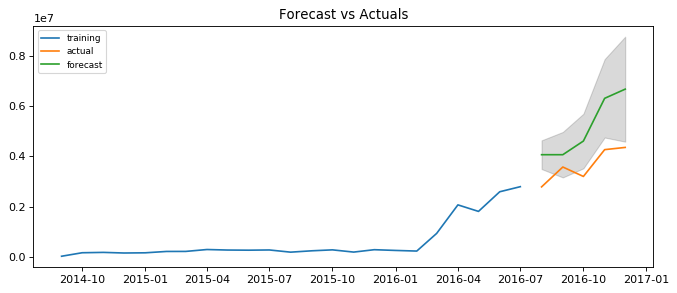

---------------------------------------------------------------------------------------------------
Denmark_2


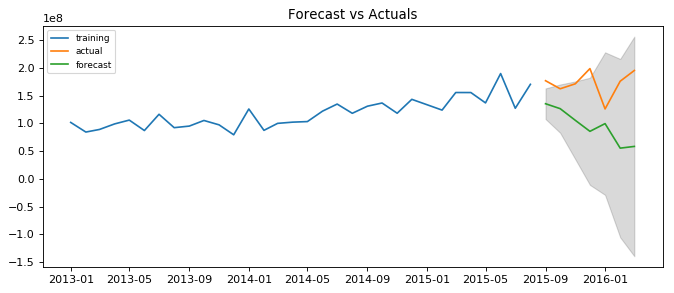

---------------------------------------------------------------------------------------------------
England_4


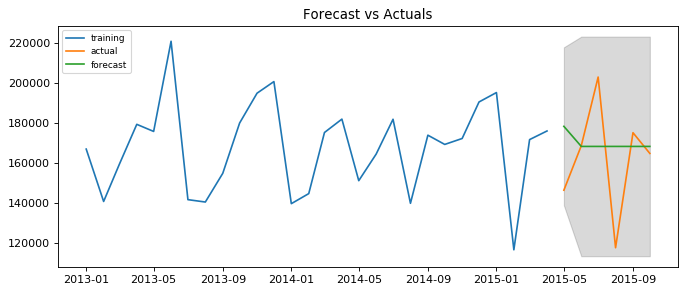

---------------------------------------------------------------------------------------------------
England_5


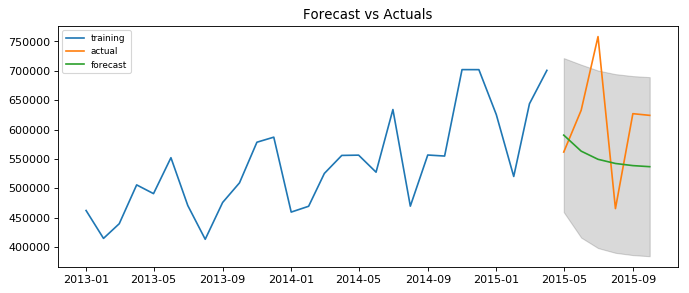

---------------------------------------------------------------------------------------------------
Finland_4


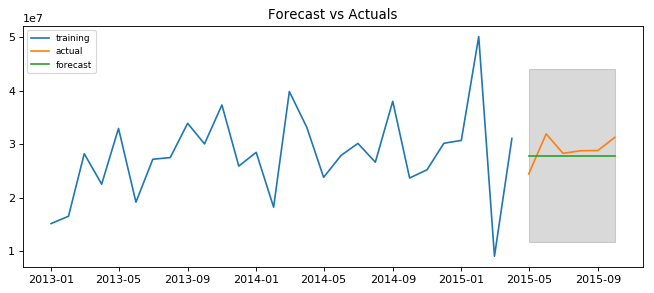

---------------------------------------------------------------------------------------------------


In [374]:
forecast_metrics = []

for key in best_models.keys():
    print (key)
    
    country, product_id = key.split('_')[0], key.split('_')[1]
    data = train_df[(train_df['Country'] == country) & (train_df['Product_ID'] == int(product_id))]
    
    data['index_'] = list(range(0, data.shape[0]))
    train_X, test_X = data[data['index_'] <= int(data.shape[0]*80/100)]['Sales'], data[data['index_'] > int(data.shape[0]*80/100)]['Sales']
    

    best_model = best_models[key]
    fc, conf = best_model.predict(len(test_X), alpha=0.05, return_conf_int=True)
    
    mape,  smape, me,  mae,  mpe, rmse, corr, minmax = get_forecast_metrics(test_X.values, fc)
    forecast_metrics.append([mape,  smape, me,  mae,  mpe, rmse, corr, minmax])
    
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_X.index)
    lower_series = pd.Series(conf[:, 0], index=test_X.index)
    upper_series = pd.Series(conf[:, 1], index=test_X.index)

    # Plot
    plt.rcParams.update({'figure.figsize':(10, 4)})
    plt.plot(train_X, label='training')
    plt.plot(test_X, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print ('---------------------------------------------------------------------------------------------------')

In [375]:
summary = []
for key in best_models.keys():
    best_model = best_models[key]
    summary.append([key.split('_')[0], key.split('_')[1], best_model.order[0], best_model.order[1], best_model.order[2], best_model.aic(), best_model.aicc(), best_model.bic()])
    
summary_without_expense_data = pd.DataFrame(data = summary, columns=['Country', 'Product_ID', 'p', 'd', 'q', 'AIC', 'AICc', 'BIC'])

forecast_metrics_df = pd.DataFrame(data = forecast_metrics, columns=['mape',  'smape', 'me','mae',  'mpe', 'rmse', 'corr', 'minmax'])
summary_without_expense_data = pd.concat([summary_without_expense_data, forecast_metrics_df], axis=1)

### ARIMAX - Forecasting using Expense Data as Exogenous variable

In [381]:
best_models = {}

for name, group in train_df.groupby(['Country', 'Product_ID']):
    print (name)
    
    group = group.sort_values('Date', ascending=True)
    ts = group['Sales'].values
    expense = group['Expense'].values
    
    train_X, test_X = ts[: int(len(ts)*80/100)], ts[int(len(ts)*80/100) :]
    expense_train, expense_test = expense[: int(len(expense)*80/100)], expense[int(len(expense)*80/100) :]
    
    if (~(((name[0] == 'Argentina') & (name[1] == 3)) | ((name[0] == 'Columbia') & (name[1] == 3)))):
        best_models[name[0] + '_' + str(name[1])] = get_model_summary(train_X, expense_train.reshape(-1, 1))
    else:
        best_models[name[0] + '_' + str(name[1])] = get_model_summary(train_X)

('Argentina', 1)
Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=973.277, BIC=977.379, Time=0.005 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=964.922, BIC=970.391, Time=0.016 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=950.596, BIC=956.065, Time=0.044 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1040.929, BIC=1043.664, Time=0.005 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=957.156, BIC=963.993, Time=0.074 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=953.831, BIC=962.035, Time=0.098 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=952.838, BIC=962.409, Time=0.134 seconds
Near non-invertible roots for order (3, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle

Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1010.198, BIC=1018.402, Time=0.114 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1018.809, BIC=1025.645, Time=0.023 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1012.052, BIC=1021.623, Time=0.113 seconds
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1012.091, BIC=1021.662, Time=0.121 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1017.580, BIC=1025.784, Time=0.203 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1015.883, BIC=1024.087, Time=0.079 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1011.419, BIC=1022.357, Time=0.189 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.052 seconds
('England', 4)
Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=510.959, BIC=514.616, Time=0.005 seconds
Fit ARIMA(1,2,0)x(0,

Argentina_1


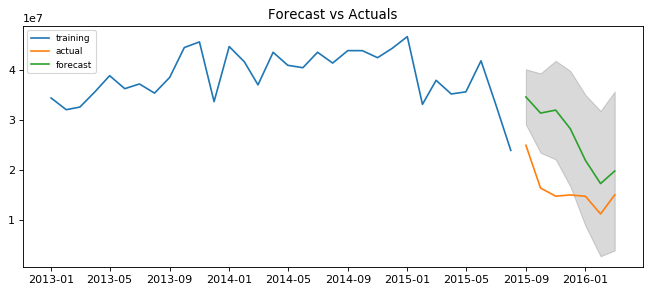

---------------------------------------------------------------------------------------------------
Argentina_2


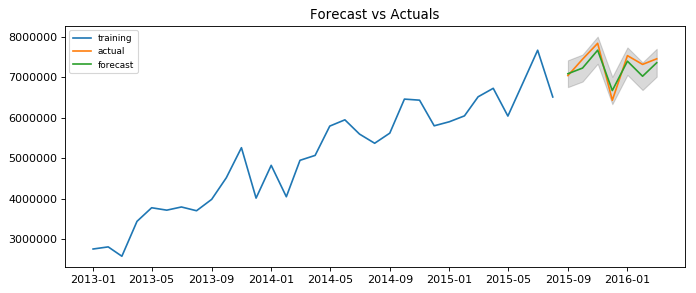

---------------------------------------------------------------------------------------------------
Argentina_3


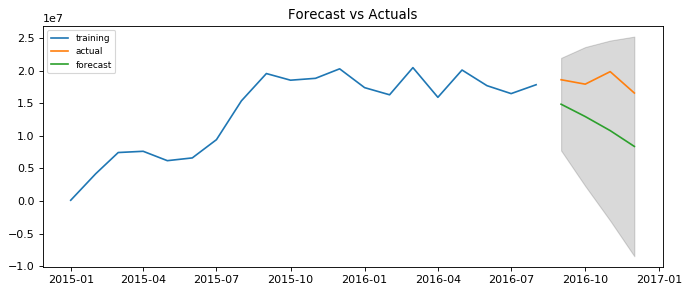

---------------------------------------------------------------------------------------------------
Belgium_2


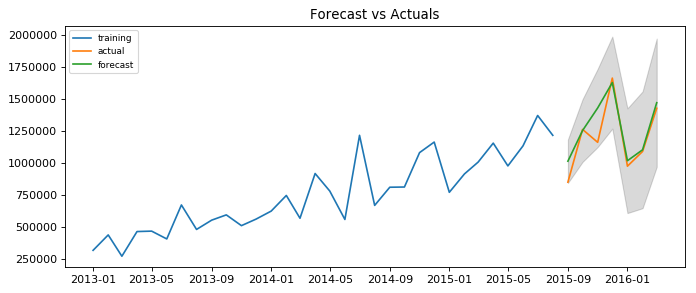

---------------------------------------------------------------------------------------------------
Columbia_1


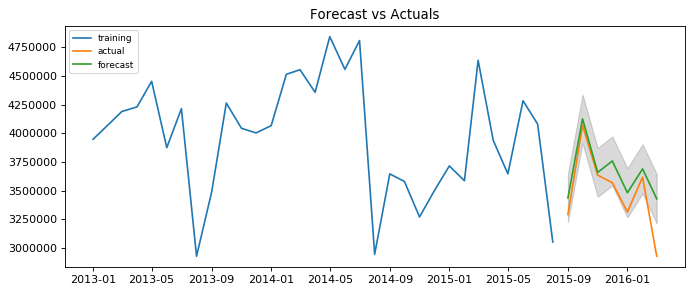

---------------------------------------------------------------------------------------------------
Columbia_2


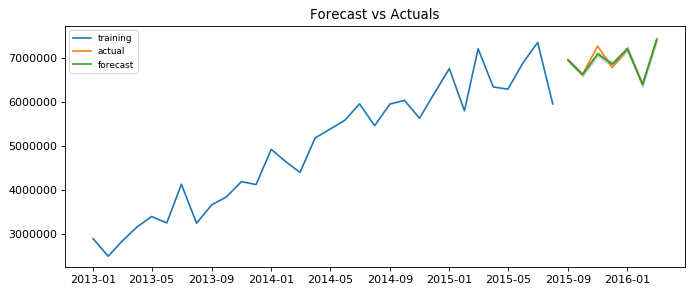

---------------------------------------------------------------------------------------------------
Columbia_3


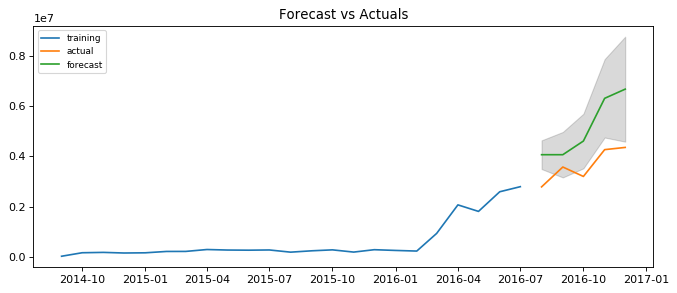

---------------------------------------------------------------------------------------------------
Denmark_2


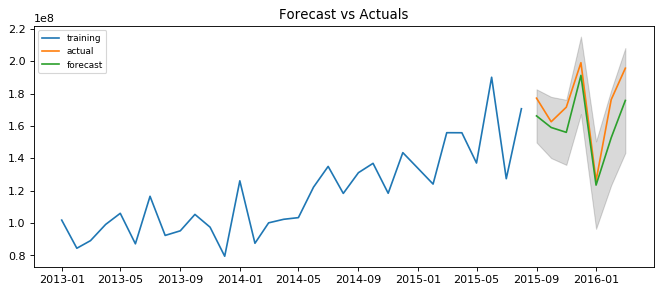

---------------------------------------------------------------------------------------------------
England_4


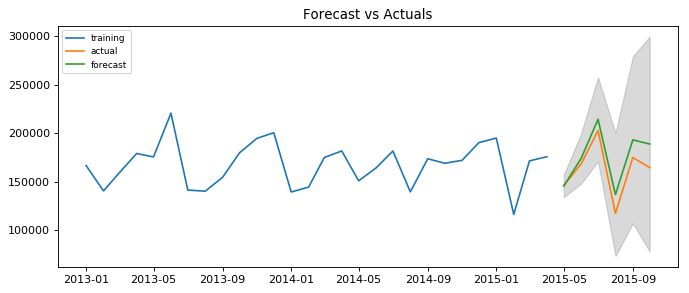

---------------------------------------------------------------------------------------------------
England_5


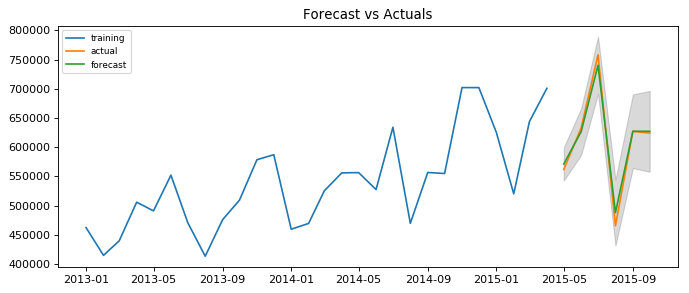

---------------------------------------------------------------------------------------------------
Finland_4


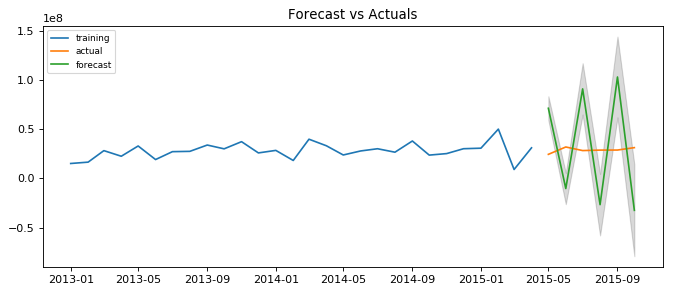

---------------------------------------------------------------------------------------------------


In [382]:
forecast_metrics = []


for key in best_models.keys():
    print (key)
    
    country, product_id = key.split('_')[0], key.split('_')[1]
    data = train_df[(train_df['Country'] == country) & (train_df['Product_ID'] == int(product_id))]
    
    data['index_'] = list(range(0, data.shape[0]))
    train_X, test_X = data[data['index_'] <= int(data.shape[0]*80/100)]['Sales'], data[data['index_'] > int(data.shape[0]*80/100)]['Sales']
    expense_train, expense_test = data[data['index_'] <= int(data.shape[0]*80/100)]['Expense'].values, data[data['index_'] > int(data.shape[0]*80/100)]['Expense'].values

    best_model = best_models[key]
    
    
    if (((name[0] != 'Argentina') & (name[1] != 3)) | ((name[0] != 'Columbia') & (name[1] != 3))):
        fc, conf = best_model.predict(len(test_X), exogenous= expense_test.reshape(-1, 1), alpha=0.05, return_conf_int=True)
    else:
        fc, conf = best_model.predict(len(test_X), alpha=0.05, return_conf_int=True)
        
    mape,  smape, me,  mae,  mpe, rmse, corr, minmax = get_forecast_metrics(test_X.values, fc)
    forecast_metrics.append([mape,  smape, me,  mae,  mpe, rmse, corr, minmax])

    
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_X.index)
    lower_series = pd.Series(conf[:, 0], index=test_X.index)
    upper_series = pd.Series(conf[:, 1], index=test_X.index)

    # Plot
    plt.rcParams.update({'figure.figsize':(10, 4)})
    plt.plot(train_X, label='training')
    plt.plot(test_X, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print ('---------------------------------------------------------------------------------------------------')

In [383]:
summary = []
for key in best_models.keys():
    best_model = best_models[key]
    summary.append([key.split('_')[0], key.split('_')[1], best_model.order[0], best_model.order[1], best_model.order[2], best_model.aic(), best_model.aicc(), best_model.bic()])
    
summary_with_expense_data = pd.DataFrame(data = summary, columns=['Country', 'Product_ID', 'p', 'd', 'q', 'AIC', 'AICc', 'BIC'])

forecast_metrics_df = pd.DataFrame(data = forecast_metrics, columns=['mape',  'smape', 'me','mae',  'mpe', 'rmse', 'corr', 'minmax'])
summary_with_expense_data = pd.concat([summary_with_expense_data, forecast_metrics_df], axis=1)

## Comparing Sales forecast with and without Expense data

In [380]:
summary_without_expense_data

,Country,Product_ID,p,d,q,AIC,AICc,BIC,mape,smape,me,mae,mpe,rmse,corr,minmax
0,Argentina,1,0,1,1,1012.899439,1013.788328,1017.103031,0.555235,19.608433,-2.006632e+07,2.006632e+07,-0.555235,2.051368e+07,-7.296493e-01,0.555235
1,Argentina,2,0,1,1,880.014346,880.903235,884.217938,0.126475,3.441521,-1.078898e+06,1.078898e+06,-0.126475,1.227296e+06,1.169080e-01,0.126475
2,Argentina,3,0,2,1,562.921731,564.521731,565.421371,0.612416,11.201437,6.480398e+06,6.480398e+06,0.612416,6.840169e+06,4.258189e-01,0.357123
3,Belgium,2,3,0,1,849.241106,852.741106,857.845030,0.173008,4.057267,5.394513e+04,1.957540e+05,0.049221,2.675448e+05,-5.065720e-02,0.142383
4,Columbia,1,0,2,1,870.758166,871.647055,874.860054,0.494102,9.066754,8.645759e+05,1.000677e+06,0.457987,1.108124e+06,5.281738e-01,0.291954
5,Columbia,2,2,2,1,858.864325,861.264325,865.700804,0.044469,1.114567,-2.466571e+04,3.092524e+05,-0.003359,3.573639e+05,-1.015376e-01,0.043293
6,Columbia,3,2,2,0,566.830867,569.183808,570.813796,0.282622,8.353589,-1.507877e+06,1.507877e+06,-0.282622,1.637593e+06,8.972102e-01,0.282622
7,Denmark,2,3,2,2,1065.865244,1070.734810,1075.436315,1.046839,14.795630,7.732894e+07,7.732894e+07,1.046839,8.810974e+07,-3.530619e-01,0.429371
8,England,4,0,0,1,620.299242,621.342720,624.186752,0.125175,3.342894,-7.373287e+03,2.135985e+04,-0.042041,2.845849e+04,-2.767654e-01,0.119022
9,England,5,1,0,0,682.868122,683.911600,686.755633,0.170051,3.915858,5.807612e+04,9.325880e+04,0.106628,1.084598e+05,-1.056437e-01,0.142711


In [384]:
summary_with_expense_data

,Country,Product_ID,p,d,q,AIC,AICc,BIC,mape,smape,me,mae,mpe,rmse,corr,minmax
0,Argentina,1,0,2,1,950.595808,952.134269,956.064991,0.382919,12.097844,-1.042054e+07,1.042054e+07,-0.382919,1.131483e+07,0.711705,0.382919
1,Argentina,2,0,2,2,793.866959,796.266959,800.703438,0.024085,0.598127,9.008027e+04,1.719956e+05,0.011924,1.894446e+05,0.947537,0.023578
2,Argentina,3,0,2,1,562.921731,564.521731,565.421371,0.612416,11.201437,6.480398e+06,6.480398e+06,0.612416,6.840169e+06,0.425819,0.357123
3,Belgium,2,0,2,1,743.708116,745.246577,749.177299,0.066050,1.776166,-6.957772e+04,8.221402e+04,-0.057802,1.219459e+05,0.920930,0.065977
4,Columbia,1,0,1,1,780.087232,781.625694,785.692022,0.046567,1.218246,-1.647595e+05,1.647595e+05,-0.046567,2.214073e+05,0.924192,0.046567
5,Columbia,2,1,0,0,701.925638,703.464100,707.661587,0.005998,0.149084,1.402462e+04,4.214390e+04,0.001968,7.344203e+04,0.977673,0.005911
6,Columbia,3,2,2,0,566.830867,569.183808,570.813796,0.282622,8.353589,-1.507877e+06,1.507877e+06,-0.282622,1.637593e+06,0.897210,0.282622
7,Denmark,2,2,2,1,1010.198096,1013.698096,1018.401871,0.074027,1.760510,1.200659e+07,1.200659e+07,0.074027,1.411182e+07,0.946952,0.067199
8,England,4,0,2,0,508.963282,509.463282,511.401033,0.075792,2.004518,-1.308524e+04,1.328266e+04,-0.074438,1.562470e+04,0.949137,0.075790
9,England,5,0,1,0,572.965580,573.465580,575.481773,0.016896,0.426108,-1.817248e+03,9.832871e+03,-0.005564,1.262402e+04,0.999484,0.016785
